# NNDL problem set 3

Author: Xiaolan Li

In [1]:
import numpy as np
import pandas as pd
from sklearn.utils import shuffle
import matplotlib.pyplot as plt

In [2]:
def append(vector):
    bias_unit = np.ones((vector.shape[0], 1), dtype=int)
    return np.append(vector, bias_unit, axis=1)

def layer_weights(n_inputs,n_neurons):
    # set random range between -0.5 to 0.5 for weights
    np.random.seed(1)
    return np.random.uniform(-0.5, 0.5, (n_inputs,n_neurons))

def forward(inputs, weights):
     return np.dot(inputs, weights)

def sigmoid(raw):
    activated = 1 / (1 + np.exp(-raw))
    return activated

def loss(Oactivated, target):
    return 0.5 * np.sum(np.dot((Oactivated - target).T, (Oactivated-target)))

def E_Wjk(Oactivated, target, Thid):      
    return Thid.T @ ((Oactivated - target) * (Oactivated * (1 - Oactivated)))
    
def E_biasO(Oactivated, target):
    return np.sum((Oactivated - target) * Oactivated * (1 - Oactivated), axis=0, keepdims=True)
    
def E_Wij(Oactivated, target, Wjk, Thid, inputs):
    E_Thid = ((Oactivated - target) * Oactivated * (1 - Oactivated)) @ Wjk.T #shape is (len(data),7)
    return inputs.T @ (E_Thid * Thid * (1 - Thid))

def E_biasH(Oactivated, Wjk, Thid, target):
    E_Thid = ((Oactivated - target) * Oactivated * (1 - Oactivated)) @ Wjk.T
    return np.sum(E_Thid * Thid * (1 - Thid), axis=0, keepdims=True)

In [3]:
# read dataset seeds
data = pd.read_csv('seeds_dataset.txt', sep='\t', header= None)
# normalize the data before training
data.iloc[:,:-1] = data.iloc[:,:-1].apply(lambda x: (x - x.min()) / (x.max() - x.min()))
# shuffle the dataset to avoid missing learning
seeds_data = shuffle(data)
inputs_orig = np.array(seeds_data)[:, :-1]
target_orig = np.array(seeds_data)[:, -1].astype(int)

# true one-hot encodings for the target
target = []
for n in target_orig:
    if n == 1:
        target.append([1,0,0])
    elif n == 2:
        target.append([0,1,0])
    elif n == 3:
        target.append([0,0,1])
    else:
        print('detected invalid target: ', n)
target = np.array(target)

In [4]:
# split train and test data to 7:3
split_pos = int(len(inputs_orig)*0.7)
train_input = inputs_orig[:split_pos]
test_input = inputs_orig[split_pos:]

train_target = target[:split_pos]
test_target = target[split_pos:]

# print 5 samples
print(train_input[:5])
print(train_target[:5])

[[0.15769594 0.24586777 0.22867514 0.2865991  0.14468995 0.51891196
  0.41408173]
 [0.17941454 0.21694215 0.52359347 0.20720721 0.24019957 0.47535399
  0.23781388]
 [0.1680831  0.21900826 0.44101633 0.17173423 0.23521026 0.41008205
  0.23732152]
 [0.30122757 0.34090909 0.61524501 0.32657658 0.37491091 0.30827341
  0.17380601]
 [0.0727101  0.1322314  0.27313975 0.15540541 0.0890948  0.42685511
  0.36632201]]
[[0 0 1]
 [0 0 1]
 [0 0 1]
 [1 0 0]
 [0 0 1]]


In [5]:
def train(inputs_orig, target, layer_neurons=[7,7,3], n_epochs=1000, learning_rate=0.05):
    # input > hidden
    inputs = inputs_orig
    n_inputs_neurons, n_hidden_neurons, n_output_neurons = layer_neurons
    
    # define initail weights and bias for three layers network
    W_inputs = layer_weights(n_inputs_neurons, n_hidden_neurons)
    W_hidden = layer_weights(n_hidden_neurons, n_output_neurons)

    biasH = layer_weights(1, n_hidden_neurons)
    biasO = layer_weights(1, n_output_neurons)

    print(f'The initial input weights:\n{W_inputs}\n')
    print(f'The initial hidden weights:\n{W_hidden}\n')
    print(f'The initial hidden bias:{biasH}')
    print(f'The initial output bias:{biasO}')
    
    # start training in neural network
    errors = []
    for epoch in range(n_epochs):
        # forward
        # inputs > hidden
        hidden_activated = sigmoid(forward(inputs, W_inputs) + biasH) 

        # hidden > output        
        output_activated = sigmoid(forward(hidden_activated, W_hidden) + biasO)
        error = loss(output_activated, target)
        errors.append(error)

        # back
        # update weights (Here using -=, so E_Wjk and E_Wij function has to use O_act - target instead of reverse, using target - O_act when +=)
        W_hidden -= E_Wjk(output_activated, target, hidden_activated) * learning_rate
        W_inputs -= E_Wij(output_activated, target, W_hidden, hidden_activated, inputs) * learning_rate

        # update bias
        biasO -= E_biasO(output_activated, target) * learning_rate
        biasH -= E_biasH(output_activated, W_hidden, hidden_activated, target) * learning_rate

    # print the updated weights and bias 
    print(f'After {n_epochs} ephos gradient')
    print(f'Updated inputs weights:\n {W_inputs} \n')
    print(f'Updated hidden weights:\n {W_hidden} \n')
    print(f'Updated hidden bias:{biasH}')
    print(f'Updated output bias:{biasO}')

    # plot the errors vs epochs
    plt.plot(np.arange(n_epochs), errors)
    plt.xlabel('n_epochs')
    plt.ylabel('error')
    return W_inputs, W_hidden, biasH, biasO

The initial input weights:
[[-0.082978    0.22032449 -0.49988563 -0.19766743 -0.35324411 -0.40766141
  -0.31373979]
 [-0.15443927 -0.10323253  0.03881673 -0.08080549  0.1852195  -0.29554775
   0.37811744]
 [-0.47261241  0.17046751 -0.0826952   0.05868983 -0.35961306 -0.30189851
   0.30074457]
 [ 0.46826158 -0.18657582  0.19232262  0.37638915  0.39460666 -0.41495579
  -0.46094522]
 [-0.33016958  0.3781425  -0.40165317 -0.07889237  0.45788953  0.03316528
   0.19187711]
 [-0.18448437  0.18650093  0.33462567 -0.48171172  0.25014431  0.48886109
   0.24816565]
 [-0.21955601  0.28927933 -0.39677399 -0.05210647  0.4085955  -0.20638585
  -0.21222466]]

The initial hidden weights:
[[-0.082978    0.22032449 -0.49988563]
 [-0.19766743 -0.35324411 -0.40766141]
 [-0.31373979 -0.15443927 -0.10323253]
 [ 0.03881673 -0.08080549  0.1852195 ]
 [-0.29554775  0.37811744 -0.47261241]
 [ 0.17046751 -0.0826952   0.05868983]
 [-0.35961306 -0.30189851  0.30074457]]

The initial hidden bias:[[-0.082978    0.2203

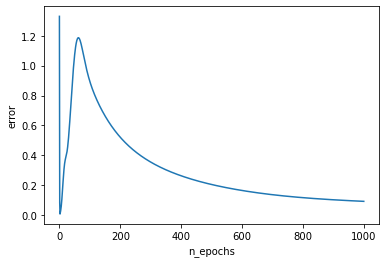

In [6]:
W_inputs, W_hidden, biasH, biasO = train(train_input, train_target)

In [7]:
# predict
hidden_activated = sigmoid(forward(test_input, W_inputs) + biasH)
output_activated = sigmoid(forward(hidden_activated, W_hidden) + biasO)
np.round(output_activated,3)

array([[0.996, 0.021, 0.001],
       [0.009, 0.997, 0.003],
       [0.024, 0.002, 0.965],
       [0.009, 0.839, 0.172],
       [0.993, 0.005, 0.009],
       [0.93 , 0.004, 0.073],
       [0.093, 0.955, 0.004],
       [0.006, 0.998, 0.005],
       [0.003, 0.998, 0.01 ],
       [0.995, 0.004, 0.006],
       [0.973, 0.01 , 0.022],
       [0.829, 0.078, 0.039],
       [0.013, 0.994, 0.005],
       [0.001, 0.001, 0.999],
       [0.027, 0.002, 0.966],
       [0.982, 0.029, 0.007],
       [0.029, 0.001, 0.964],
       [0.991, 0.014, 0.007],
       [0.023, 0.945, 0.024],
       [0.013, 0.001, 0.982],
       [0.027, 0.994, 0.001],
       [0.013, 0.001, 0.985],
       [0.999, 0.004, 0.001],
       [0.033, 0.977, 0.006],
       [0.36 , 0.002, 0.645],
       [0.067, 0.001, 0.935],
       [0.917, 0.226, 0.003],
       [0.714, 0.002, 0.299],
       [0.979, 0.002, 0.034],
       [0.018, 0.99 , 0.006],
       [0.986, 0.002, 0.018],
       [0.982, 0.008, 0.016],
       [0.008, 0.996, 0.005],
       [0.

In [8]:
# prediction and accuracy
y_pred = np.argmax(output_activated, axis=1) 
y_target = np.argmax(test_target, axis=1)
res = y_pred == y_target
accuracy = np.sum(res)/len(res)
accuracy

0.9206349206349206